In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.model_selection import train_test_split

In [12]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical, multi_gpu_model, Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
data_dir = 'data/'

In [5]:
# train_data = np.load(path.join(data_dir, 'imagenet_6_class_172_train_data.npz'))
# val_data = np.load(path.join(data_dir, 'imagenet_6_class_172_val_data.npz'))

x_train = np.load(path.join(data_dir, 'imagenet_6_class_172_x_train.npy'))
y_train = np.load(path.join(data_dir, 'imagenet_6_class_172_y_train.npy'))
x_val = np.load(path.join(data_dir, 'imagenet_6_class_172_x_val.npy'))
y_val = np.load(path.join(data_dir, 'imagenet_6_class_172_y_val.npy'))
y_list = np.load(path.join(data_dir, 'imagenet_6_class_172_y_list.npy'))

In [6]:
# x_train = train_data['x_data']
# y_train = train_data['y_data']
# x_val = val_data['x_data']
# y_val = val_data['y_data']
x_test = x_val
y_test = y_val
# y_list = val_data['y_list']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_list.shape

((235111, 172, 172, 3),
 (235111,),
 (3183, 172, 172, 3),
 (3183,),
 (3183, 172, 172, 3),
 (3183,),
 (6,))

In [7]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = y_val

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((235111, 172, 172, 3),
 (235111, 6),
 (3183, 172, 172, 3),
 (3183, 6),
 (3183, 172, 172, 3),
 (3183, 6))

In [8]:
input_shape = x_train[0].shape
output_size = len(y_list)

In [9]:
def build_2d_cnn_custom_ch_32_DO(conv_num=1):
    input_layer = Input(shape=input_shape)
    x = input_layer

    for i in range(conv_num):
        x = Conv2D(kernel_size=5, filters=32*(2**(i//2)), strides=(1,1), padding='same')(x)
#         x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D(pool_size=3, strides=(2,2), padding='same')(x)

    x = Flatten()(x)
  
    x = Dropout(0.5)(x)
    output_layer = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [10]:
for i in range(1, 8):
    model = build_2d_cnn_custom_ch_32_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 172, 172, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 172, 172, 32)      2432      
_________________________________________________________________
activation (Activation)      (None, 172, 172, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 86, 86, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 236672)            0         
_________________________________________________________________
dropout (Dropout)    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 172, 172, 3)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 172, 172, 32)      2432      
_________________________________________________________________
activation_21 (Activation)   (None, 172, 172, 32)      0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 86, 86, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 86, 86, 32)        25632     
_________________________________________________________________
activation_22 (Activation)   (None, 86, 86, 32)        0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 43, 43, 32)        0         
__________

In [13]:
class BalanceDataGenerator(Sequence):
    def __init__(self, x_data, y_data, batch_size, shuffle=True):
        self.x_data = x_data
        self.y_data = y_data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.sample_size = int(np.sum(y_data, axis=0).min())
        self.data_shape = x_data.shape[1:]
        self.y_labels = np.unique(y_data)
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.y_labels) * self.sample_size / self.batch_size))

    def on_epoch_end(self):
        self.indexes = np.zeros((len(self.y_labels), self.sample_size))
        for i, label in enumerate(self.y_labels):
            y_temp = self.y_data.argmax(axis=1)
            y_index = np.argwhere(y_temp==label).squeeze()
            if self.shuffle == True:
                self.indexes[i] = np.random.choice(y_index, 
                                   self.sample_size, 
                                   replace=False)
            else:
                self.indexes[i] = y_index[:self.sample_size]
                
        self.indexes = self.indexes.flatten().astype(np.int32)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
                
    def __getitem__(self, batch_idx):
        indices = self.indexes[batch_idx*self.batch_size: (batch_idx+1)*self.batch_size]
        return self.x_data[indices], self.y_data[indices]    

In [14]:
batch_size = 40
data_generator = BalanceDataGenerator(x_train, y_train,
                                      batch_size=batch_size)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10000
3200/3183 [==============================] - 12s 4ms/sample - loss: 0.7330 - acc: 0.4625

Epoch 00001: val_loss improved from inf to 0.73301, saving model to model/checkpoint/vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_050_DO_3_conv_checkpoint/001-0.7330.hdf5
81/81 [==============================] - 17s 208ms/step - loss: 0.7156 - acc: 0.5940 - val_loss: 0.7330 - val_acc: 0.4625
Epoch 2/10000
3200/3183 [==============================] - 12s 4ms/sample - loss: 0.3026 - acc: 0.9191

Epoch 00002: val_loss improved from 0.73301 to 0.30255, saving model to model/checkpoint/vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_050_DO_3_conv_checkpoint/002-0.3026.hdf5
81/81 [==============================] - 17s 210ms/step - loss: 0.5105 - acc: 0.7517 - val_loss: 0.3026 - val_acc: 0.9191
Epoch 3/10000
3190/3183 [==============================] - 11s 4ms/sample - loss: 0.4351 - acc: 0.7950

Epoch 00003: val_loss did 

Epoch 15/10000
3200/3183 [==============================] - 13s 4ms/sample - loss: 0.0978 - acc: 0.9700

Epoch 00015: val_loss improved from 0.09849 to 0.09783, saving model to model/checkpoint/vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_050_DO_3_conv_checkpoint/015-0.0978.hdf5
81/81 [==============================] - 22s 270ms/step - loss: 0.2026 - acc: 0.9224 - val_loss: 0.0978 - val_acc: 0.9700
Epoch 16/10000
3200/3183 [==============================] - 12s 4ms/sample - loss: 0.1416 - acc: 0.9575

Epoch 00016: val_loss did not improve from 0.09783
81/81 [==============================] - 18s 221ms/step - loss: 0.1704 - acc: 0.9342 - val_loss: 0.1416 - val_acc: 0.9575
Epoch 17/10000
3200/3183 [==============================] - 13s 4ms/sample - loss: 0.1107 - acc: 0.9600

Epoch 00017: val_loss did not improve from 0.09783
81/81 [==============================] - 20s 243ms/step - loss: 0.1594 - acc: 0.9407 - val_loss: 0.1107 - val_acc: 0.9600
Epoch 18/10000
3200/3183 [====

3200/3183 [==============================] - 66s 21ms/sample - loss: 0.0853 - acc: 0.9659

Epoch 00029: val_loss did not improve from 0.06307
81/81 [==============================] - 71s 872ms/step - loss: 0.1298 - acc: 0.9525 - val_loss: 0.0853 - val_acc: 0.9659
Epoch 30/10000
3200/3183 [==============================] - 63s 20ms/sample - loss: 0.0639 - acc: 0.9681

Epoch 00030: val_loss did not improve from 0.06307
81/81 [==============================] - 69s 857ms/step - loss: 0.1177 - acc: 0.9609 - val_loss: 0.0639 - val_acc: 0.9681
Epoch 31/10000
3200/3183 [==============================] - 65s 20ms/sample - loss: 0.0678 - acc: 0.9669

Epoch 00031: val_loss did not improve from 0.06307
81/81 [==============================] - 71s 876ms/step - loss: 0.1232 - acc: 0.9559 - val_loss: 0.0678 - val_acc: 0.9669
Epoch 32/10000
3200/3183 [==============================] - 64s 20ms/sample - loss: 0.0563 - acc: 0.9834

Epoch 00032: val_loss improved from 0.06307 to 0.05626, saving model to 

3200/3183 [==============================] - 15s 5ms/sample - loss: 0.0855 - acc: 0.9663

Epoch 00044: val_loss did not improve from 0.05384
81/81 [==============================] - 72s 885ms/step - loss: 0.1015 - acc: 0.9665 - val_loss: 0.0855 - val_acc: 0.9663
Epoch 45/10000
3200/3183 [==============================] - 68s 21ms/sample - loss: 0.0805 - acc: 0.9675

Epoch 00045: val_loss did not improve from 0.05384
81/81 [==============================] - 73s 902ms/step - loss: 0.1014 - acc: 0.9637 - val_loss: 0.0805 - val_acc: 0.9675
Epoch 46/10000
3200/3183 [==============================] - 68s 21ms/sample - loss: 0.0508 - acc: 0.9825

Epoch 00046: val_loss improved from 0.05384 to 0.05080, saving model to model/checkpoint/vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_050_DO_3_conv_checkpoint/046-0.0508.hdf5
81/81 [==============================] - 72s 890ms/step - loss: 0.1068 - acc: 0.9618 - val_loss: 0.0508 - val_acc: 0.9825
Epoch 47/10000
3200/3183 [=================

3200/3183 [==============================] - 67s 21ms/sample - loss: 0.1136 - acc: 0.9591

Epoch 00059: val_loss did not improve from 0.04722
81/81 [==============================] - 73s 897ms/step - loss: 0.0831 - acc: 0.9708 - val_loss: 0.1136 - val_acc: 0.9591
Epoch 60/10000
3200/3183 [==============================] - 70s 22ms/sample - loss: 0.0415 - acc: 0.9850

Epoch 00060: val_loss improved from 0.04722 to 0.04153, saving model to model/checkpoint/vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_050_DO_3_conv_checkpoint/060-0.0415.hdf5
81/81 [==============================] - 74s 917ms/step - loss: 0.0876 - acc: 0.9683 - val_loss: 0.0415 - val_acc: 0.9850
Epoch 61/10000
3200/3183 [==============================] - 68s 21ms/sample - loss: 0.0795 - acc: 0.9675

Epoch 00061: val_loss did not improve from 0.04153
81/81 [==============================] - 77s 948ms/step - loss: 0.0805 - acc: 0.9724 - val_loss: 0.0795 - val_acc: 0.9675
Epoch 62/10000
3200/3183 [================

Epoch 75/10000
3200/3183 [==============================] - 68s 21ms/sample - loss: 0.0681 - acc: 0.9700

Epoch 00075: val_loss did not improve from 0.04153
81/81 [==============================] - 75s 922ms/step - loss: 0.0662 - acc: 0.9777 - val_loss: 0.0681 - val_acc: 0.9700
Epoch 76/10000
3200/3183 [==============================] - 44s 14ms/sample - loss: 0.0639 - acc: 0.9787

Epoch 00076: val_loss did not improve from 0.04153
81/81 [==============================] - 74s 914ms/step - loss: 0.0775 - acc: 0.9727 - val_loss: 0.0639 - val_acc: 0.9787
Epoch 77/10000
3200/3183 [==============================] - 69s 22ms/sample - loss: 0.0517 - acc: 0.9837

Epoch 00077: val_loss did not improve from 0.04153
81/81 [==============================] - 74s 912ms/step - loss: 0.0674 - acc: 0.9814 - val_loss: 0.0517 - val_acc: 0.9837
Epoch 78/10000
3200/3183 [==============================] - 67s 21ms/sample - loss: 0.0975 - acc: 0.9628

Epoch 00078: val_loss did not improve from 0.04153
81/81 

3200/3183 [==============================] - 14s 4ms/sample - loss: 0.1437 - acc: 0.9491

Epoch 00090: val_loss did not improve from 0.04153
81/81 [==============================] - 73s 903ms/step - loss: 0.0602 - acc: 0.9792 - val_loss: 0.1437 - val_acc: 0.9491
Epoch 91/10000
3200/3183 [==============================] - 70s 22ms/sample - loss: 0.0454 - acc: 0.9819

Epoch 00091: val_loss did not improve from 0.04153
81/81 [==============================] - 74s 917ms/step - loss: 0.0601 - acc: 0.9808 - val_loss: 0.0454 - val_acc: 0.9819
Epoch 92/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0562 - acc: 0.9812

Epoch 00092: val_loss did not improve from 0.04153
81/81 [==============================] - 72s 886ms/step - loss: 0.0606 - acc: 0.9823 - val_loss: 0.0562 - val_acc: 0.9812
Epoch 93/10000
3200/3183 [==============================] - 68s 21ms/sample - loss: 0.0463 - acc: 0.9834

Epoch 00093: val_loss did not improve from 0.04153
81/81 [================

3200/3183 [==============================] - 70s 22ms/sample - loss: 0.0613 - acc: 0.9737

Epoch 00106: val_loss did not improve from 0.04153
81/81 [==============================] - 75s 923ms/step - loss: 0.0529 - acc: 0.9811 - val_loss: 0.0613 - val_acc: 0.9737
Epoch 107/10000
3200/3183 [==============================] - 65s 20ms/sample - loss: 0.0437 - acc: 0.9816

Epoch 00107: val_loss did not improve from 0.04153
81/81 [==============================] - 74s 918ms/step - loss: 0.0532 - acc: 0.9814 - val_loss: 0.0437 - val_acc: 0.9816
Epoch 108/10000
3200/3183 [==============================] - 74s 23ms/sample - loss: 0.0710 - acc: 0.9725

Epoch 00108: val_loss did not improve from 0.04153
81/81 [==============================] - 79s 978ms/step - loss: 0.0585 - acc: 0.9804 - val_loss: 0.0710 - val_acc: 0.9725
Epoch 109/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 0.0495 - acc: 0.9806

Epoch 00109: val_loss did not improve from 0.04153
81/81 [============

3200/3183 [==============================] - 72s 23ms/sample - loss: 0.0584 - acc: 0.9822

Epoch 00121: val_loss did not improve from 0.03852
81/81 [==============================] - 76s 937ms/step - loss: 0.0477 - acc: 0.9851 - val_loss: 0.0584 - val_acc: 0.9822
Epoch 122/10000
3200/3183 [==============================] - 71s 22ms/sample - loss: 0.0575 - acc: 0.9787

Epoch 00122: val_loss did not improve from 0.03852
81/81 [==============================] - 75s 927ms/step - loss: 0.0476 - acc: 0.9854 - val_loss: 0.0575 - val_acc: 0.9787
Epoch 123/10000
3200/3183 [==============================] - 72s 22ms/sample - loss: 0.0624 - acc: 0.9825

Epoch 00123: val_loss did not improve from 0.03852
81/81 [==============================] - 76s 942ms/step - loss: 0.0315 - acc: 0.9904 - val_loss: 0.0624 - val_acc: 0.9825
Epoch 124/10000
3200/3183 [==============================] - 71s 22ms/sample - loss: 0.0468 - acc: 0.9825

Epoch 00124: val_loss did not improve from 0.03852
81/81 [===========

3200/3183 [==============================] - 15s 5ms/sample - loss: 0.0460 - acc: 0.9806

Epoch 00136: val_loss did not improve from 0.03852
81/81 [==============================] - 73s 895ms/step - loss: 0.0320 - acc: 0.9904 - val_loss: 0.0460 - val_acc: 0.9806
Epoch 137/10000
3200/3183 [==============================] - 76s 24ms/sample - loss: 0.0451 - acc: 0.9875

Epoch 00137: val_loss did not improve from 0.03852
81/81 [==============================] - 79s 981ms/step - loss: 0.0420 - acc: 0.9867 - val_loss: 0.0451 - val_acc: 0.9875
Epoch 138/10000
3200/3183 [==============================] - 73s 23ms/sample - loss: 0.0407 - acc: 0.9900

Epoch 00138: val_loss did not improve from 0.03852
81/81 [==============================] - 77s 948ms/step - loss: 0.0288 - acc: 0.9910 - val_loss: 0.0407 - val_acc: 0.9900
Epoch 139/10000
3200/3183 [==============================] - 72s 22ms/sample - loss: 0.0594 - acc: 0.9775

Epoch 00139: val_loss did not improve from 0.03852
81/81 [============

3200/3183 [==============================] - 69s 22ms/sample - loss: 0.0482 - acc: 0.9837

Epoch 00152: val_loss did not improve from 0.03852
81/81 [==============================] - 73s 903ms/step - loss: 0.0348 - acc: 0.9922 - val_loss: 0.0482 - val_acc: 0.9837
Epoch 153/10000
3200/3183 [==============================] - 71s 22ms/sample - loss: 0.0785 - acc: 0.9737

Epoch 00153: val_loss did not improve from 0.03852
81/81 [==============================] - 75s 930ms/step - loss: 0.0262 - acc: 0.9932 - val_loss: 0.0785 - val_acc: 0.9737
Epoch 154/10000
3200/3183 [==============================] - 72s 22ms/sample - loss: 0.0567 - acc: 0.9725

Epoch 00154: val_loss did not improve from 0.03852
81/81 [==============================] - 75s 928ms/step - loss: 0.0329 - acc: 0.9898 - val_loss: 0.0567 - val_acc: 0.9725
Epoch 155/10000
3200/3183 [==============================] - 70s 22ms/sample - loss: 0.0486 - acc: 0.9800

Epoch 00155: val_loss did not improve from 0.03852
81/81 [===========

3200/3183 [==============================] - 47s 15ms/sample - loss: 0.0618 - acc: 0.9850

Epoch 00167: val_loss did not improve from 0.03852
81/81 [==============================] - 78s 959ms/step - loss: 0.0305 - acc: 0.9919 - val_loss: 0.0618 - val_acc: 0.9850
Epoch 168/10000
3200/3183 [==============================] - 75s 23ms/sample - loss: 0.0448 - acc: 0.9900

Epoch 00168: val_loss did not improve from 0.03852
81/81 [==============================] - 79s 977ms/step - loss: 0.0276 - acc: 0.9932 - val_loss: 0.0448 - val_acc: 0.9900
Epoch 169/10000
3200/3183 [==============================] - 74s 23ms/sample - loss: 0.0522 - acc: 0.9906

Epoch 00169: val_loss did not improve from 0.03852
81/81 [==============================] - 79s 972ms/step - loss: 0.0232 - acc: 0.9947 - val_loss: 0.0522 - val_acc: 0.9906
Epoch 170/10000
3200/3183 [==============================] - 47s 15ms/sample - loss: 0.0580 - acc: 0.9850

Epoch 00170: val_loss did not improve from 0.03852
81/81 [===========

3200/3183 [==============================] - 72s 22ms/sample - loss: 0.0466 - acc: 0.9906

Epoch 00183: val_loss did not improve from 0.03852
81/81 [==============================] - 78s 960ms/step - loss: 0.0285 - acc: 0.9926 - val_loss: 0.0466 - val_acc: 0.9906
Epoch 184/10000
3200/3183 [==============================] - 74s 23ms/sample - loss: 0.0887 - acc: 0.9787

Epoch 00184: val_loss did not improve from 0.03852
81/81 [==============================] - 78s 964ms/step - loss: 0.0386 - acc: 0.9863 - val_loss: 0.0887 - val_acc: 0.9787
Epoch 185/10000
3200/3183 [==============================] - 72s 23ms/sample - loss: 0.0515 - acc: 0.9850

Epoch 00185: val_loss did not improve from 0.03852
81/81 [==============================] - 76s 938ms/step - loss: 0.0265 - acc: 0.9904 - val_loss: 0.0515 - val_acc: 0.9850
Epoch 186/10000
3200/3183 [==============================] - 72s 22ms/sample - loss: 0.0607 - acc: 0.9809

Epoch 00186: val_loss did not improve from 0.03852
81/81 [===========

3200/3183 [==============================] - 44s 14ms/sample - loss: 0.0608 - acc: 0.9850

Epoch 00198: val_loss did not improve from 0.03852
81/81 [==============================] - 76s 942ms/step - loss: 0.0208 - acc: 0.9960 - val_loss: 0.0608 - val_acc: 0.9850
Epoch 199/10000
3200/3183 [==============================] - 15s 5ms/sample - loss: 0.0571 - acc: 0.9847

Epoch 00199: val_loss did not improve from 0.03852
81/81 [==============================] - 76s 943ms/step - loss: 0.0239 - acc: 0.9935 - val_loss: 0.0571 - val_acc: 0.9847
Epoch 200/10000
3200/3183 [==============================] - 73s 23ms/sample - loss: 0.0464 - acc: 0.9891

Epoch 00200: val_loss did not improve from 0.03852
81/81 [==============================] - 77s 955ms/step - loss: 0.0239 - acc: 0.9950 - val_loss: 0.0464 - val_acc: 0.9891
Epoch 201/10000
3200/3183 [==============================] - 73s 23ms/sample - loss: 0.0498 - acc: 0.9894

Epoch 00201: val_loss did not improve from 0.03852
81/81 [============

3200/3183 [==============================] - 74s 23ms/sample - loss: 0.0526 - acc: 0.9875

Epoch 00214: val_loss did not improve from 0.03852
81/81 [==============================] - 77s 955ms/step - loss: 0.0206 - acc: 0.9950 - val_loss: 0.0526 - val_acc: 0.9875
Epoch 215/10000
3200/3183 [==============================] - 15s 5ms/sample - loss: 0.0761 - acc: 0.9753

Epoch 00215: val_loss did not improve from 0.03852
81/81 [==============================] - 75s 920ms/step - loss: 0.0290 - acc: 0.9919 - val_loss: 0.0761 - val_acc: 0.9753
Epoch 216/10000
3200/3183 [==============================] - 19s 6ms/sample - loss: 0.0510 - acc: 0.9894

Epoch 00216: val_loss did not improve from 0.03852
81/81 [==============================] - 78s 957ms/step - loss: 0.0269 - acc: 0.9935 - val_loss: 0.0510 - val_acc: 0.9894

vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_050_DO_3_conv Model


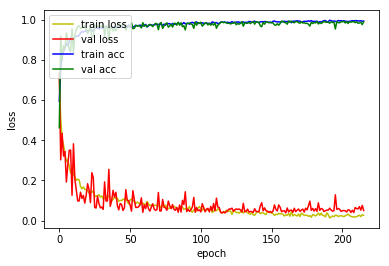

3183/3183 [==============================] - 3s 1ms/sample - loss: 10.6577 - acc: 0.3365
Loss: 10.657696457540672 Accuracy: 0.336475

Epoch 1/10000
3200/3183 [==============================] - 47s 15ms/sample - loss: 0.7991 - acc: 0.2084

Epoch 00001: val_loss improved from inf to 0.79913, saving model to model/checkpoint/vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_050_DO_4_conv_checkpoint/001-0.7991.hdf5
81/81 [==============================] - 54s 666ms/step - loss: 0.8186 - acc: 0.5317 - val_loss: 0.7991 - val_acc: 0.2084
Epoch 2/10000
3200/3183 [==============================] - 70s 22ms/sample - loss: 0.3795 - acc: 0.8794

Epoch 00002: val_loss improved from 0.79913 to 0.37954, saving model to model/checkpoint/vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_050_DO_4_conv_checkpoint/002-0.3795.hdf5
81/81 [==============================] - 75s 923ms/step - loss: 0.6112 - acc: 0.6747 - val_loss: 0.3795 - val_acc: 0.8794
Epoch 3/10000
3190/3183 [=================

3200/3183 [==============================] - 72s 23ms/sample - loss: 0.2152 - acc: 0.9109

Epoch 00015: val_loss did not improve from 0.08147
81/81 [==============================] - 78s 957ms/step - loss: 0.1677 - acc: 0.9373 - val_loss: 0.2152 - val_acc: 0.9109
Epoch 16/10000
3200/3183 [==============================] - 56s 18ms/sample - loss: 0.1158 - acc: 0.9600

Epoch 00016: val_loss did not improve from 0.08147
81/81 [==============================] - 86s 1s/step - loss: 0.1452 - acc: 0.9488 - val_loss: 0.1158 - val_acc: 0.9600
Epoch 17/10000
3200/3183 [==============================] - 70s 22ms/sample - loss: 0.1878 - acc: 0.9306

Epoch 00017: val_loss did not improve from 0.08147
81/81 [==============================] - 78s 968ms/step - loss: 0.1606 - acc: 0.9438 - val_loss: 0.1878 - val_acc: 0.9306
Epoch 18/10000
3200/3183 [==============================] - 72s 23ms/sample - loss: 0.0648 - acc: 0.9778

Epoch 00018: val_loss improved from 0.08147 to 0.06484, saving model to mod

3200/3183 [==============================] - 73s 23ms/sample - loss: 0.0571 - acc: 0.9800

Epoch 00030: val_loss improved from 0.06484 to 0.05710, saving model to model/checkpoint/vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_050_DO_4_conv_checkpoint/030-0.0571.hdf5
81/81 [==============================] - 77s 948ms/step - loss: 0.1346 - acc: 0.9491 - val_loss: 0.0571 - val_acc: 0.9800
Epoch 31/10000
3200/3183 [==============================] - 71s 22ms/sample - loss: 0.1012 - acc: 0.9619

Epoch 00031: val_loss did not improve from 0.05710
81/81 [==============================] - 77s 949ms/step - loss: 0.1270 - acc: 0.9550 - val_loss: 0.1012 - val_acc: 0.9619
Epoch 32/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.1748 - acc: 0.9269

Epoch 00032: val_loss did not improve from 0.05710
81/81 [==============================] - 74s 916ms/step - loss: 0.1129 - acc: 0.9578 - val_loss: 0.1748 - val_acc: 0.9269
Epoch 33/10000
3200/3183 [=================

81/81 [==============================] - 79s 979ms/step - loss: 0.0893 - acc: 0.9668 - val_loss: 0.0455 - val_acc: 0.9869
Epoch 46/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0987 - acc: 0.9688

Epoch 00046: val_loss did not improve from 0.04549
81/81 [==============================] - 76s 941ms/step - loss: 0.0832 - acc: 0.9718 - val_loss: 0.0987 - val_acc: 0.9688
Epoch 47/10000
3200/3183 [==============================] - 18s 6ms/sample - loss: 0.1234 - acc: 0.9513

Epoch 00047: val_loss did not improve from 0.04549
81/81 [==============================] - 80s 982ms/step - loss: 0.0867 - acc: 0.9714 - val_loss: 0.1234 - val_acc: 0.9513
Epoch 48/10000
3200/3183 [==============================] - 75s 23ms/sample - loss: 0.0741 - acc: 0.9706

Epoch 00048: val_loss did not improve from 0.04549
81/81 [==============================] - 80s 984ms/step - loss: 0.0938 - acc: 0.9618 - val_loss: 0.0741 - val_acc: 0.9706
Epoch 49/10000
3200/3183 [=================

3200/3183 [==============================] - 50s 16ms/sample - loss: 0.0905 - acc: 0.9700

Epoch 00061: val_loss did not improve from 0.04549
81/81 [==============================] - 82s 1s/step - loss: 0.0783 - acc: 0.9727 - val_loss: 0.0905 - val_acc: 0.9700
Epoch 62/10000
3200/3183 [==============================] - 72s 22ms/sample - loss: 0.1004 - acc: 0.9609

Epoch 00062: val_loss did not improve from 0.04549
81/81 [==============================] - 77s 945ms/step - loss: 0.0852 - acc: 0.9699 - val_loss: 0.1004 - val_acc: 0.9609
Epoch 63/10000
3200/3183 [==============================] - 78s 24ms/sample - loss: 0.0689 - acc: 0.97723s - loss: 0.0616 - ac

Epoch 00063: val_loss did not improve from 0.04549
81/81 [==============================] - 82s 1s/step - loss: 0.0739 - acc: 0.9777 - val_loss: 0.0689 - val_acc: 0.9772
Epoch 64/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 0.0430 - acc: 0.9887

Epoch 00064: val_loss improved from 0.04549 to 0.04303, s

3200/3183 [==============================] - 74s 23ms/sample - loss: 0.0607 - acc: 0.9816

Epoch 00076: val_loss did not improve from 0.03826
81/81 [==============================] - 77s 957ms/step - loss: 0.0636 - acc: 0.9780 - val_loss: 0.0607 - val_acc: 0.9816
Epoch 77/10000
3200/3183 [==============================] - 75s 23ms/sample - loss: 0.0507 - acc: 0.9834

Epoch 00077: val_loss did not improve from 0.03826
81/81 [==============================] - 79s 970ms/step - loss: 0.0631 - acc: 0.9773 - val_loss: 0.0507 - val_acc: 0.9834
Epoch 78/10000
3200/3183 [==============================] - 73s 23ms/sample - loss: 0.0579 - acc: 0.9775

Epoch 00078: val_loss did not improve from 0.03826
81/81 [==============================] - 77s 951ms/step - loss: 0.0696 - acc: 0.9764 - val_loss: 0.0579 - val_acc: 0.9775
Epoch 79/10000
3200/3183 [==============================] - 74s 23ms/sample - loss: 0.0587 - acc: 0.9809

Epoch 00079: val_loss did not improve from 0.03826
81/81 [==============

3200/3183 [==============================] - 74s 23ms/sample - loss: 0.0457 - acc: 0.9831

Epoch 00091: val_loss did not improve from 0.03729
81/81 [==============================] - 78s 961ms/step - loss: 0.0549 - acc: 0.9836 - val_loss: 0.0457 - val_acc: 0.9831
Epoch 92/10000
3200/3183 [==============================] - 74s 23ms/sample - loss: 0.0480 - acc: 0.9850

Epoch 00092: val_loss did not improve from 0.03729
81/81 [==============================] - 88s 1s/step - loss: 0.0542 - acc: 0.9823 - val_loss: 0.0480 - val_acc: 0.9850
Epoch 93/10000
3200/3183 [==============================] - 68s 21ms/sample - loss: 0.0440 - acc: 0.9850

Epoch 00093: val_loss did not improve from 0.03729
81/81 [==============================] - 77s 949ms/step - loss: 0.0533 - acc: 0.9842 - val_loss: 0.0440 - val_acc: 0.9850
Epoch 94/10000
3200/3183 [==============================] - 72s 22ms/sample - loss: 0.0425 - acc: 0.9912

Epoch 00094: val_loss did not improve from 0.03729
81/81 [=================

Epoch 107/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0723 - acc: 0.9700

Epoch 00107: val_loss did not improve from 0.03430
81/81 [==============================] - 75s 920ms/step - loss: 0.0553 - acc: 0.9820 - val_loss: 0.0723 - val_acc: 0.9700
Epoch 108/10000
3200/3183 [==============================] - 75s 23ms/sample - loss: 0.0490 - acc: 0.9850

Epoch 00108: val_loss did not improve from 0.03430
81/81 [==============================] - 80s 983ms/step - loss: 0.0487 - acc: 0.9836 - val_loss: 0.0490 - val_acc: 0.9850
Epoch 109/10000
3200/3183 [==============================] - 78s 24ms/sample - loss: 0.0478 - acc: 0.9875

Epoch 00109: val_loss did not improve from 0.03430
81/81 [==============================] - 83s 1s/step - loss: 0.0471 - acc: 0.9851 - val_loss: 0.0478 - val_acc: 0.9875
Epoch 110/10000
3200/3183 [==============================] - 77s 24ms/sample - loss: 0.0408 - acc: 0.9862

Epoch 00110: val_loss did not improve from 0.03430
81/81 

3200/3183 [==============================] - 72s 22ms/sample - loss: 0.0453 - acc: 0.9825

Epoch 00122: val_loss did not improve from 0.03009
81/81 [==============================] - 76s 936ms/step - loss: 0.0330 - acc: 0.9901 - val_loss: 0.0453 - val_acc: 0.9825
Epoch 123/10000
3200/3183 [==============================] - 14s 4ms/sample - loss: 0.0427 - acc: 0.9887

Epoch 00123: val_loss did not improve from 0.03009
81/81 [==============================] - 76s 941ms/step - loss: 0.0447 - acc: 0.9885 - val_loss: 0.0427 - val_acc: 0.9887
Epoch 124/10000
3200/3183 [==============================] - 25s 8ms/sample - loss: 0.0359 - acc: 0.9916

Epoch 00124: val_loss did not improve from 0.03009
81/81 [==============================] - 83s 1s/step - loss: 0.0353 - acc: 0.9863 - val_loss: 0.0359 - val_acc: 0.9916
Epoch 125/10000
3200/3183 [==============================] - 78s 24ms/sample - loss: 0.0437 - acc: 0.9875

Epoch 00125: val_loss did not improve from 0.03009
81/81 [================

Epoch 138/10000
3200/3183 [==============================] - 70s 22ms/sample - loss: 0.0416 - acc: 0.9819

Epoch 00138: val_loss did not improve from 0.02680
81/81 [==============================] - 79s 978ms/step - loss: 0.0313 - acc: 0.9894 - val_loss: 0.0416 - val_acc: 0.9819
Epoch 139/10000
3200/3183 [==============================] - 70s 22ms/sample - loss: 0.0486 - acc: 0.9809

Epoch 00139: val_loss did not improve from 0.02680
81/81 [==============================] - 75s 923ms/step - loss: 0.0228 - acc: 0.9938 - val_loss: 0.0486 - val_acc: 0.9809
Epoch 140/10000
3200/3183 [==============================] - 68s 21ms/sample - loss: 0.0350 - acc: 0.9922

Epoch 00140: val_loss did not improve from 0.02680
81/81 [==============================] - 74s 907ms/step - loss: 0.0334 - acc: 0.9891 - val_loss: 0.0350 - val_acc: 0.9922
Epoch 141/10000
3200/3183 [==============================] - 73s 23ms/sample - loss: 0.0514 - acc: 0.9875

Epoch 00141: val_loss did not improve from 0.02680
81

3190/3183 [==============================] - 44s 14ms/sample - loss: 0.0380 - acc: 0.9922

Epoch 00153: val_loss did not improve from 0.02617
81/81 [==============================] - 75s 922ms/step - loss: 0.0387 - acc: 0.9876 - val_loss: 0.0380 - val_acc: 0.9922
Epoch 154/10000
3200/3183 [==============================] - 20s 6ms/sample - loss: 0.0333 - acc: 0.9900

Epoch 00154: val_loss did not improve from 0.02617
81/81 [==============================] - 82s 1s/step - loss: 0.0301 - acc: 0.9910 - val_loss: 0.0333 - val_acc: 0.9900
Epoch 155/10000
3200/3183 [==============================] - 71s 22ms/sample - loss: 0.0387 - acc: 0.9891

Epoch 00155: val_loss did not improve from 0.02617
81/81 [==============================] - 82s 1s/step - loss: 0.0242 - acc: 0.9953 - val_loss: 0.0387 - val_acc: 0.9891
Epoch 156/10000
3200/3183 [==============================] - 72s 23ms/sample - loss: 0.0391 - acc: 0.9925

Epoch 00156: val_loss did not improve from 0.02617
81/81 [==================

3200/3183 [==============================] - 74s 23ms/sample - loss: 0.0274 - acc: 0.9925

Epoch 00169: val_loss did not improve from 0.02617
81/81 [==============================] - 83s 1s/step - loss: 0.0371 - acc: 0.9873 - val_loss: 0.0274 - val_acc: 0.9925
Epoch 170/10000
3200/3183 [==============================] - 71s 22ms/sample - loss: 0.0397 - acc: 0.9872

Epoch 00170: val_loss did not improve from 0.02617
81/81 [==============================] - 78s 963ms/step - loss: 0.0179 - acc: 0.9950 - val_loss: 0.0397 - val_acc: 0.9872
Epoch 171/10000
3200/3183 [==============================] - 71s 22ms/sample - loss: 0.0437 - acc: 0.9837

Epoch 00171: val_loss did not improve from 0.02617
81/81 [==============================] - 77s 946ms/step - loss: 0.0219 - acc: 0.9922 - val_loss: 0.0437 - val_acc: 0.9837
Epoch 172/10000
3200/3183 [==============================] - 74s 23ms/sample - loss: 0.0351 - acc: 0.9891

Epoch 00172: val_loss did not improve from 0.02617
81/81 [==============

3200/3183 [==============================] - 22s 7ms/sample - loss: 0.0255 - acc: 0.9894

Epoch 00184: val_loss improved from 0.02617 to 0.02549, saving model to model/checkpoint/vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_050_DO_4_conv_checkpoint/184-0.0255.hdf5
81/81 [==============================] - 78s 959ms/step - loss: 0.0306 - acc: 0.9901 - val_loss: 0.0255 - val_acc: 0.9894
Epoch 185/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0388 - acc: 0.9944

Epoch 00185: val_loss did not improve from 0.02549
81/81 [==============================] - 76s 938ms/step - loss: 0.0281 - acc: 0.9904 - val_loss: 0.0388 - val_acc: 0.9944
Epoch 186/10000
3200/3183 [==============================] - 67s 21ms/sample - loss: 0.0250 - acc: 0.9900

Epoch 00186: val_loss improved from 0.02549 to 0.02502, saving model to model/checkpoint/vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_050_DO_4_conv_checkpoint/186-0.0250.hdf5
81/81 [=====================

3200/3183 [==============================] - 73s 23ms/sample - loss: 0.0341 - acc: 0.9875

Epoch 00199: val_loss did not improve from 0.01660
81/81 [==============================] - 79s 978ms/step - loss: 0.0258 - acc: 0.9910 - val_loss: 0.0341 - val_acc: 0.9875
Epoch 200/10000
3200/3183 [==============================] - 45s 14ms/sample - loss: 0.0222 - acc: 0.9925

Epoch 00200: val_loss did not improve from 0.01660
81/81 [==============================] - 76s 938ms/step - loss: 0.0182 - acc: 0.9947 - val_loss: 0.0222 - val_acc: 0.9925
Epoch 201/10000
3200/3183 [==============================] - 18s 5ms/sample - loss: 0.0313 - acc: 0.9897

Epoch 00201: val_loss did not improve from 0.01660
81/81 [==============================] - 76s 943ms/step - loss: 0.0214 - acc: 0.9941 - val_loss: 0.0313 - val_acc: 0.9897
Epoch 202/10000
3200/3183 [==============================] - 65s 20ms/sample - loss: 0.0461 - acc: 0.9950

Epoch 00202: val_loss did not improve from 0.01660
81/81 [============

3200/3183 [==============================] - 72s 22ms/sample - loss: 0.0316 - acc: 0.9947

Epoch 00215: val_loss did not improve from 0.01660
81/81 [==============================] - 76s 944ms/step - loss: 0.0142 - acc: 0.9957 - val_loss: 0.0316 - val_acc: 0.9947
Epoch 216/10000
3200/3183 [==============================] - 72s 22ms/sample - loss: 0.0351 - acc: 0.9922

Epoch 00216: val_loss did not improve from 0.01660
81/81 [==============================] - 80s 986ms/step - loss: 0.0258 - acc: 0.9922 - val_loss: 0.0351 - val_acc: 0.9922
Epoch 217/10000
3200/3183 [==============================] - 14s 4ms/sample - loss: 0.0353 - acc: 0.9887

Epoch 00217: val_loss did not improve from 0.01660
81/81 [==============================] - 75s 930ms/step - loss: 0.0160 - acc: 0.9947 - val_loss: 0.0353 - val_acc: 0.9887
Epoch 218/10000
3200/3183 [==============================] - 74s 23ms/sample - loss: 0.0501 - acc: 0.9887

Epoch 00218: val_loss did not improve from 0.01660
81/81 [============

3200/3183 [==============================] - 68s 21ms/sample - loss: 0.0245 - acc: 0.9919

Epoch 00230: val_loss did not improve from 0.01660
81/81 [==============================] - 76s 934ms/step - loss: 0.0233 - acc: 0.9929 - val_loss: 0.0245 - val_acc: 0.9919
Epoch 231/10000
3200/3183 [==============================] - 75s 23ms/sample - loss: 0.0242 - acc: 0.9922

Epoch 00231: val_loss did not improve from 0.01660
81/81 [==============================] - 80s 985ms/step - loss: 0.0147 - acc: 0.9957 - val_loss: 0.0242 - val_acc: 0.9922
Epoch 232/10000
3200/3183 [==============================] - 46s 14ms/sample - loss: 0.0340 - acc: 0.9922

Epoch 00232: val_loss did not improve from 0.01660
81/81 [==============================] - 77s 957ms/step - loss: 0.0283 - acc: 0.9904 - val_loss: 0.0340 - val_acc: 0.9922
Epoch 233/10000
3200/3183 [==============================] - 72s 22ms/sample - loss: 0.0198 - acc: 0.9944

Epoch 00233: val_loss did not improve from 0.01660
81/81 [===========

3200/3183 [==============================] - 66s 21ms/sample - loss: 0.0494 - acc: 0.9841

Epoch 00246: val_loss did not improve from 0.01660
81/81 [==============================] - 75s 931ms/step - loss: 0.0163 - acc: 0.9957 - val_loss: 0.0494 - val_acc: 0.9841
Epoch 247/10000
3200/3183 [==============================] - 67s 21ms/sample - loss: 0.0539 - acc: 0.9950

Epoch 00247: val_loss did not improve from 0.01660
81/81 [==============================] - 77s 952ms/step - loss: 0.0107 - acc: 0.9969 - val_loss: 0.0539 - val_acc: 0.9950
Epoch 248/10000
3200/3183 [==============================] - 73s 23ms/sample - loss: 0.0313 - acc: 0.9925

Epoch 00248: val_loss did not improve from 0.01660
81/81 [==============================] - 77s 951ms/step - loss: 0.0212 - acc: 0.9929 - val_loss: 0.0313 - val_acc: 0.9925
Epoch 249/10000
3200/3183 [==============================] - 71s 22ms/sample - loss: 0.0396 - acc: 0.9900

Epoch 00249: val_loss did not improve from 0.01660
81/81 [===========

3200/3183 [==============================] - 73s 23ms/sample - loss: 0.0272 - acc: 0.9897

Epoch 00261: val_loss did not improve from 0.01660
81/81 [==============================] - 78s 962ms/step - loss: 0.0080 - acc: 0.9972 - val_loss: 0.0272 - val_acc: 0.9897
Epoch 262/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0216 - acc: 0.9922

Epoch 00262: val_loss did not improve from 0.01660
81/81 [==============================] - 73s 906ms/step - loss: 0.0233 - acc: 0.9950 - val_loss: 0.0216 - val_acc: 0.9922
Epoch 263/10000
3200/3183 [==============================] - 57s 18ms/sample - loss: 0.0247 - acc: 0.9922

Epoch 00263: val_loss did not improve from 0.01660
81/81 [==============================] - 76s 940ms/step - loss: 0.0131 - acc: 0.9953 - val_loss: 0.0247 - val_acc: 0.9922
Epoch 264/10000
3200/3183 [==============================] - 17s 5ms/sample - loss: 0.0388 - acc: 0.9919

Epoch 00264: val_loss did not improve from 0.01660
81/81 [=============

Epoch 277/10000
3200/3183 [==============================] - 69s 21ms/sample - loss: 0.0313 - acc: 0.9937

Epoch 00277: val_loss did not improve from 0.01588
81/81 [==============================] - 81s 1s/step - loss: 0.0176 - acc: 0.9929 - val_loss: 0.0313 - val_acc: 0.9937
Epoch 278/10000
3200/3183 [==============================] - ETA: 0s - loss: 0.0263 - acc: 0.991 - 16s 5ms/sample - loss: 0.0260 - acc: 0.9912

Epoch 00278: val_loss did not improve from 0.01588
81/81 [==============================] - 77s 956ms/step - loss: 0.0097 - acc: 0.9978 - val_loss: 0.0260 - val_acc: 0.9912
Epoch 279/10000
3200/3183 [==============================] - 74s 23ms/sample - loss: 0.0472 - acc: 0.9931

Epoch 00279: val_loss did not improve from 0.01588
81/81 [==============================] - 79s 976ms/step - loss: 0.0172 - acc: 0.9978 - val_loss: 0.0472 - val_acc: 0.9931
Epoch 280/10000
3200/3183 [==============================] - 66s 20ms/sample - loss: 0.0347 - acc: 0.9947

Epoch 00280: val_lo

3200/3183 [==============================] - 22s 7ms/sample - loss: 0.0282 - acc: 0.9950

Epoch 00292: val_loss did not improve from 0.01588
81/81 [==============================] - 81s 1000ms/step - loss: 0.0217 - acc: 0.9929 - val_loss: 0.0282 - val_acc: 0.9950
Epoch 293/10000
3200/3183 [==============================] - 67s 21ms/sample - loss: 0.0226 - acc: 0.9934

Epoch 00293: val_loss did not improve from 0.01588
81/81 [==============================] - 80s 988ms/step - loss: 0.0146 - acc: 0.9953 - val_loss: 0.0226 - val_acc: 0.9934
Epoch 294/10000
3200/3183 [==============================] - 76s 24ms/sample - loss: 0.0332 - acc: 0.9941

Epoch 00294: val_loss did not improve from 0.01588
81/81 [==============================] - 82s 1s/step - loss: 0.0042 - acc: 0.9991 - val_loss: 0.0332 - val_acc: 0.9941
Epoch 295/10000
3200/3183 [==============================] - 76s 24ms/sample - loss: 0.0375 - acc: 0.9947

Epoch 00295: val_loss did not improve from 0.01588
81/81 [==============

Epoch 308/10000
3200/3183 [==============================] - 67s 21ms/sample - loss: 0.0318 - acc: 0.9944

Epoch 00308: val_loss did not improve from 0.01588
81/81 [==============================] - 77s 953ms/step - loss: 0.0116 - acc: 0.9969 - val_loss: 0.0318 - val_acc: 0.9944
Epoch 309/10000
3200/3183 [==============================] - 48s 15ms/sample - loss: 0.0290 - acc: 0.9934

Epoch 00309: val_loss did not improve from 0.01588
81/81 [==============================] - 80s 986ms/step - loss: 0.0158 - acc: 0.9950 - val_loss: 0.0290 - val_acc: 0.9934
Epoch 310/10000
3190/3183 [==============================] - 16s 5ms/sample - loss: 0.0234 - acc: 0.9925

Epoch 00310: val_loss did not improve from 0.01588
81/81 [==============================] - 74s 920ms/step - loss: 0.0093 - acc: 0.9972 - val_loss: 0.0234 - val_acc: 0.9925
Epoch 311/10000
3200/3183 [==============================] - 68s 21ms/sample - loss: 0.0286 - acc: 0.9925

Epoch 00311: val_loss did not improve from 0.01588
81/

3200/3183 [==============================] - 59s 18ms/sample - loss: 0.0349 - acc: 0.9950

Epoch 00323: val_loss did not improve from 0.01410
81/81 [==============================] - 89s 1s/step - loss: 0.0109 - acc: 0.9978 - val_loss: 0.0349 - val_acc: 0.9950
Epoch 324/10000
3200/3183 [==============================] - 69s 22ms/sample - loss: 0.0250 - acc: 0.9887

Epoch 00324: val_loss did not improve from 0.01410
81/81 [==============================] - 79s 974ms/step - loss: 0.0138 - acc: 0.9953 - val_loss: 0.0250 - val_acc: 0.9887
Epoch 325/10000
3200/3183 [==============================] - 74s 23ms/sample - loss: 0.0119 - acc: 0.9950

Epoch 00325: val_loss improved from 0.01410 to 0.01195, saving model to model/checkpoint/vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_050_DO_4_conv_checkpoint/325-0.0119.hdf5
81/81 [==============================] - 78s 960ms/step - loss: 0.0139 - acc: 0.9957 - val_loss: 0.0119 - val_acc: 0.9950
Epoch 326/10000
3200/3183 [================

Epoch 339/10000
3200/3183 [==============================] - 73s 23ms/sample - loss: 0.0506 - acc: 0.9944

Epoch 00339: val_loss did not improve from 0.01195
81/81 [==============================] - 79s 975ms/step - loss: 0.0078 - acc: 0.9978 - val_loss: 0.0506 - val_acc: 0.9944
Epoch 340/10000
3200/3183 [==============================] - 70s 22ms/sample - loss: 0.0493 - acc: 0.9925

Epoch 00340: val_loss did not improve from 0.01195
81/81 [==============================] - 78s 958ms/step - loss: 0.0089 - acc: 0.9975 - val_loss: 0.0493 - val_acc: 0.9925
Epoch 341/10000
3200/3183 [==============================] - 15s 5ms/sample - loss: 0.0578 - acc: 0.9950

Epoch 00341: val_loss did not improve from 0.01195
81/81 [==============================] - 71s 876ms/step - loss: 0.0039 - acc: 0.9994 - val_loss: 0.0578 - val_acc: 0.9950
Epoch 342/10000
3200/3183 [==============================] - 16s 5ms/sample - loss: 0.0360 - acc: 0.994711s - los

Epoch 00342: val_loss did not improve from 0.0

3200/3183 [==============================] - 74s 23ms/sample - loss: 0.0340 - acc: 0.9944

Epoch 00354: val_loss did not improve from 0.01195
81/81 [==============================] - 80s 987ms/step - loss: 0.0077 - acc: 0.9988 - val_loss: 0.0340 - val_acc: 0.9944
Epoch 355/10000
3200/3183 [==============================] - 74s 23ms/sample - loss: 0.0464 - acc: 0.9950

Epoch 00355: val_loss did not improve from 0.01195
81/81 [==============================] - 77s 952ms/step - loss: 0.0055 - acc: 0.9991 - val_loss: 0.0464 - val_acc: 0.9950
Epoch 356/10000
3200/3183 [==============================] - 70s 22ms/sample - loss: 0.0492 - acc: 0.9950

Epoch 00356: val_loss did not improve from 0.01195
81/81 [==============================] - 76s 935ms/step - loss: 0.0176 - acc: 0.9960 - val_loss: 0.0492 - val_acc: 0.9950
Epoch 357/10000
3190/3183 [==============================] - 73s 23ms/sample - loss: 0.0434 - acc: 0.9950

Epoch 00357: val_loss did not improve from 0.01195
81/81 [===========

3190/3183 [==============================] - 74s 23ms/sample - loss: 0.0283 - acc: 0.9950

Epoch 00370: val_loss did not improve from 0.01195
81/81 [==============================] - 78s 961ms/step - loss: 0.0108 - acc: 0.9966 - val_loss: 0.0283 - val_acc: 0.9950
Epoch 371/10000
3200/3183 [==============================] - 15s 5ms/sample - loss: 0.0332 - acc: 0.9947

Epoch 00371: val_loss did not improve from 0.01195
81/81 [==============================] - 73s 902ms/step - loss: 0.0052 - acc: 0.9991 - val_loss: 0.0332 - val_acc: 0.9947
Epoch 372/10000
3200/3183 [==============================] - 68s 21ms/sample - loss: 0.0199 - acc: 0.9916

Epoch 00372: val_loss did not improve from 0.01195
81/81 [==============================] - 75s 926ms/step - loss: 0.0104 - acc: 0.9966 - val_loss: 0.0199 - val_acc: 0.9916
Epoch 373/10000
3200/3183 [==============================] - 72s 22ms/sample - loss: 0.0332 - acc: 0.9947

Epoch 00373: val_loss did not improve from 0.01195
81/81 [============

3200/3183 [==============================] - 72s 23ms/sample - loss: 0.0350 - acc: 0.9916

Epoch 00385: val_loss did not improve from 0.01195
81/81 [==============================] - 76s 944ms/step - loss: 0.0062 - acc: 0.9981 - val_loss: 0.0350 - val_acc: 0.9916
Epoch 386/10000
3200/3183 [==============================] - 73s 23ms/sample - loss: 0.0505 - acc: 0.9950

Epoch 00386: val_loss did not improve from 0.01195
81/81 [==============================] - 77s 946ms/step - loss: 0.0123 - acc: 0.9953 - val_loss: 0.0505 - val_acc: 0.9950
Epoch 387/10000
3190/3183 [==============================] - 14s 4ms/sample - loss: 0.0503 - acc: 0.9947

Epoch 00387: val_loss did not improve from 0.01195
81/81 [==============================] - 74s 916ms/step - loss: 0.0118 - acc: 0.9953 - val_loss: 0.0503 - val_acc: 0.9947
Epoch 388/10000
3200/3183 [==============================] - 50s 16ms/sample - loss: 0.0346 - acc: 0.9944

Epoch 00388: val_loss did not improve from 0.01195
81/81 [============

3200/3183 [==============================] - 73s 23ms/sample - loss: 0.0332 - acc: 0.9941

Epoch 00401: val_loss did not improve from 0.01195
81/81 [==============================] - 78s 964ms/step - loss: 0.0078 - acc: 0.9978 - val_loss: 0.0332 - val_acc: 0.9941
Epoch 402/10000
3200/3183 [==============================] - 46s 15ms/sample - loss: 0.0302 - acc: 0.9944

Epoch 00402: val_loss did not improve from 0.01195
81/81 [==============================] - 76s 943ms/step - loss: 0.0069 - acc: 0.9975 - val_loss: 0.0302 - val_acc: 0.9944
Epoch 403/10000
3200/3183 [==============================] - 69s 21ms/sample - loss: 0.0307 - acc: 0.9941

Epoch 00403: val_loss did not improve from 0.01195
81/81 [==============================] - 74s 908ms/step - loss: 0.0108 - acc: 0.9972 - val_loss: 0.0307 - val_acc: 0.9941
Epoch 404/10000
3200/3183 [==============================] - 76s 24ms/sample - loss: 0.0262 - acc: 0.9941

Epoch 00404: val_loss did not improve from 0.01195
81/81 [===========

3200/3183 [==============================] - 47s 15ms/sample - loss: 0.0336 - acc: 0.9944

Epoch 00416: val_loss did not improve from 0.01195
81/81 [==============================] - 78s 960ms/step - loss: 0.0052 - acc: 0.9978 - val_loss: 0.0336 - val_acc: 0.9944
Epoch 417/10000
3200/3183 [==============================] - 73s 23ms/sample - loss: 0.0453 - acc: 0.9922

Epoch 00417: val_loss did not improve from 0.01195
81/81 [==============================] - 78s 961ms/step - loss: 0.0100 - acc: 0.9960 - val_loss: 0.0453 - val_acc: 0.9922
Epoch 418/10000
3200/3183 [==============================] - 73s 23ms/sample - loss: 0.0286 - acc: 0.9947

Epoch 00418: val_loss did not improve from 0.01195
81/81 [==============================] - 76s 941ms/step - loss: 0.0124 - acc: 0.9975 - val_loss: 0.0286 - val_acc: 0.9947
Epoch 419/10000
79/81 [============================>.] - ETA: 0s - loss: 0.0041 - acc: 0.9990WARNING:tensorflow:Using a generator with `use_multiprocessing=True` and multiple w

KeyboardInterrupt: 

In [15]:
for i in range(3, 8):
    base = 'vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_050_DO'
    model_name = base+'_{}_conv'.format(i)
    
#     with tf.device('/cpu:0'):
    model = build_2d_cnn_custom_ch_32_DO(conv_num=i)
#     model = multi_gpu_model(model, gpus=2)
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=100)
    hist = model.fit_generator(data_generator,
            steps_per_epoch=len(x_train)//batch_size,
            epochs=10000,
            validation_data=(x_val, y_val),
            callbacks = [checkpointer, early_stopping],
            workers=8, 
            use_multiprocessing=True
    )
    
    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test, y_test)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [ ]:
del(model)

In [ ]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = 'vis_imagenet_6_class_augmentation_2D_CNN_custom_ch_32_DO_050_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 8):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test, y_test)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')

In [ ]:
for i in range(3, 8):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test, y_test)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)